In [2]:
from implementation_functions import *

import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose

import pandas as pd
import numpy as np
from prince import FAMD #Factor analysis of mixed data
from aif360.metrics import BinaryLabelDatasetMetric
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import skfuzzy as fuzz

In [3]:
#import the dataset and get the initial statistics
# SKIP THIS BLOCK IF YOU ARE ALREADY IMPORTING A DF (except sensitive attr and decision label definition)
data_name = "adult"
dataset_orig, privileged_groups, unprivileged_groups = aif_data(data_name, False)

In [4]:
sens_attr = ['race', 'sex']
decision_label = 'income-per-year'
# Getting the baseline peformance results from the imbalanced dataset
fav_l = 1
unfav_l = 0

In [5]:
# Initial disparities in the full original dataset
metric_orig = BinaryLabelDatasetMetric(dataset_orig, 
                                              unprivileged_groups=unprivileged_groups,
                                              privileged_groups=privileged_groups)
print("Disparate impact (of original labels) between unprivileged and privileged groups = %f" % metric_orig.disparate_impact())
print("Difference in statistical parity (of original labels) between unprivileged and privileged groups = %f" % metric_orig.statistical_parity_difference())
print("Individual fairness metric that measures how similar the labels are for similar instances = %f" % metric_orig.consistency())

Disparate impact (of original labels) between unprivileged and privileged groups = 0.234951
Difference in statistical parity (of original labels) between unprivileged and privileged groups = -0.247806


c:\users\hatta\anaconda3\envs\aif360\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass n_neighbors=5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Individual fairness metric that measures how similar the labels are for similar instances = 0.848485


In [6]:
# Creating the snythetic sub-class label column and num-cat columns identification
orig_df, num_list, cat_list = preprocess(dataset_orig, sens_attr, decision_label)

#remove unwanted columns in the analysis to reduce dimensionality
cols = [c for c in orig_df.columns if c.lower()[:14] != 'native-country']
orig_df = orig_df[cols]
orig_df = orig_df.drop(['education-num'], axis=1)

#renew the list of categ and numeric columns if you do the processing above
num_list, cat_list = type_lists(orig_df)

# The list of sub-group sizes in the dataset (to monitor the dist. of sub-groups)
orig_df.reset_index(drop=True, inplace=True)
orig_df['sub_labels'].value_counts()

6    18268
2    10428
7     8752
4     2720
0     2598
3     1455
5      787
1      214
Name: sub_labels, dtype: int64

In [7]:
# EQUALIZE THE POSITIVE AND THE NEGATIVE CLASS SIZES (due to extreme # of negative cases)
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='majority')
X = orig_df.loc[:, orig_df.columns != 'income-per-year']
y = orig_df.loc[:, orig_df.columns == 'income-per-year']
y=y.astype('int')
X_over, y_over = undersample.fit_resample(X, y)
new_df = pd.concat([X_over, pd.DataFrame(y_over)], axis=1)
orig_df = new_df
#new subgroup counts
print(orig_df['sub_labels'].value_counts())

7    8752
6    5964
2    3435
3    1455
4     927
0     882
5     787
1     214
Name: sub_labels, dtype: int64


In [8]:
# Train-test split WITH stratification
X = orig_df.loc[:, orig_df.columns != decision_label]
y = orig_df.loc[:, orig_df.columns == decision_label].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    shuffle=True,
                                                    stratify=X['sub_labels'])

In [10]:
# Check class imbalance in the splitted training set
print(X_train['sub_labels'].value_counts())
print(X_test['sub_labels'].value_counts())

# Partial feture scaling (of numerical variables)
X_train, X_test = scale(X_train, X_test)
num_list, cat_list = type_lists(X_train)

7    6126
6    4175
2    2404
3    1019
4     649
0     617
5     551
1     150
Name: sub_labels, dtype: int64
7    2626
6    1789
2    1031
3     436
4     278
0     265
5     236
1      64
Name: sub_labels, dtype: int64


In [12]:
# Type the desired classifier to train the classification models with model obj
clf = GradientBoostingClassifier()
baseline_stats, cm, ratio_table, preds = baseline_metrics(clf, X_train, X_test, 
                                                  y_train, y_test, sens_attr, 
                                                  fav_l, unfav_l)

In [13]:
baseline_stats

,AEO Difference,Disparate Impact Ratio,Dem Parity Difference,Predictive Parity Difference,Consistency,Accuracy,Balanced accuracy,F1-Score,Precision (PPV),Recall (TPR),Specificity (TNR)
"[{'race': 0, 'sex': 0}][{'race': 1, 'sex': 0}]",-0.030480,0.636995,-0.098731,-0.020050,0.916848,0.835836,0.835842,0.84147,0.813437,0.871505,0.800178
"[{'race': 1, 'sex': 0}][{'race': 0, 'sex': 1}]",-0.121264,0.533586,-0.237744,0.050718,0.916848,0.835836,0.835842,0.84147,0.813437,0.871505,0.800178
"[{'race': 0, 'sex': 1}][{'race': 1, 'sex': 1}]",-0.059963,0.780322,-0.143500,-0.016786,0.916848,0.835836,0.835842,0.84147,0.813437,0.871505,0.800178
"[{'race': 0, 'sex': 0}][{'race': 0, 'sex': 1}]",-0.151745,0.339892,-0.336475,0.030668,0.916848,0.835836,0.835842,0.84147,0.813437,0.871505,0.800178
"[{'race': 1, 'sex': 0}][{'race': 1, 'sex': 1}]",-0.181227,0.416369,-0.381244,0.033932,0.916848,0.835836,0.835842,0.84147,0.813437,0.871505,0.800178
"[{'race': 0, 'sex': 0}][{'race': 1, 'sex': 1}]",-0.211708,0.265225,-0.479975,0.013882,0.916848,0.835836,0.835842,0.84147,0.813437,0.871505,0.800178


In [14]:
cm

{'TP': 2930.0, 'FP': 672.0, 'TN': 2691.0, 'FN': 432.0}

In [15]:
ratio_table

,Base Ratio,Positive Ratio,Negative Ratio
Index,,,
"{'race': 0, 'sex': 0}",0.048922,0.008476,0.040446
"{'race': 1, 'sex': 0}",0.218141,0.059331,0.158810
"{'race': 0, 'sex': 1}",0.076431,0.038959,0.037472
"{'race': 1, 'sex': 1}",0.656506,0.428848,0.227658


In [16]:
preds

,0,1,2,3,race,sex,workclass=Federal-gov,workclass=Local-gov,workclass=Private,workclass=Self-emp-inc,...,occupation=Sales,occupation=Tech-support,occupation=Transport-moving,relationship=Husband,relationship=Not-in-family,relationship=Other-relative,relationship=Own-child,relationship=Unmarried,relationship=Wife,y_pred
0,0.095890,0.0,0.000000,0.010204,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0.0
1,0.643836,0.0,0.000000,0.397959,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1.0
2,0.205479,0.0,0.000000,0.459184,1,1,0,0,1,0,...,1,0,0,1,0,0,0,0,0,1.0
3,0.315068,0.0,0.000000,0.142857,1,1,0,0,0,1,...,0,0,0,1,0,0,0,0,0,1.0
4,0.095890,0.0,0.000000,0.653061,1,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6720,0.273973,0.0,0.424242,0.397959,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1.0
6721,0.561644,0.0,0.000000,0.459184,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0.0
6722,0.178082,0.0,0.000000,0.500000,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0.0
6723,0.287671,0.0,0.000000,0.295918,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0.0


In [17]:
# Keep the subgroup labels to append them back later
keep_sub_l = X_train['sub_labels']
# Required drops for the ADULT dataset (THIS DF CREATION IS A MUST)
X_train_new = X_train.drop(['race', 'sex', 'sub_labels'], axis=1)

# Get the idx of categ and numeric columns again due to the column drops above
num_list, cat_list = type_lists(X_train_new)

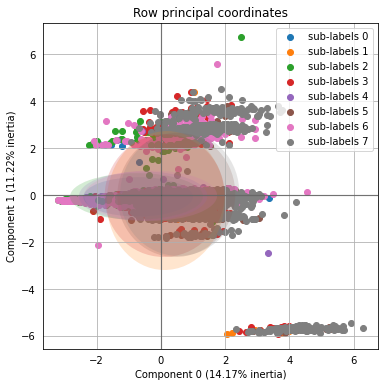

In [18]:
# Dimensionality reduction for big datasets with FAMD
X_train_new['sub_labels'] = keep_sub_l

famd = FAMD(n_components=2, random_state = 42)
famd.fit(X_train_new.drop('sub_labels', axis=1))
X_train_reduc = famd.transform(X_train_new)
#plotting the reduced dimensions
ax = famd.plot_row_coordinates(X_train_new, 
                                 color_labels=['sub-labels {}'.format(t) for t in X_train_new['sub_labels']])
# X_train_red = famd.partial_row_coordinates(X_train_new)
# famd.explained_inertia_
# ax = famd.plot_partial_row_coordinates(X_train_new, 
#                                         color_labels=['sub-labels {}'.format(t) for t in X_train_new['sub_labels']])
                               
# Delete the subgroup label column again if dimensionality reduction is used
X_train_new = X_train_new.drop(['sub_labels'], axis=1)

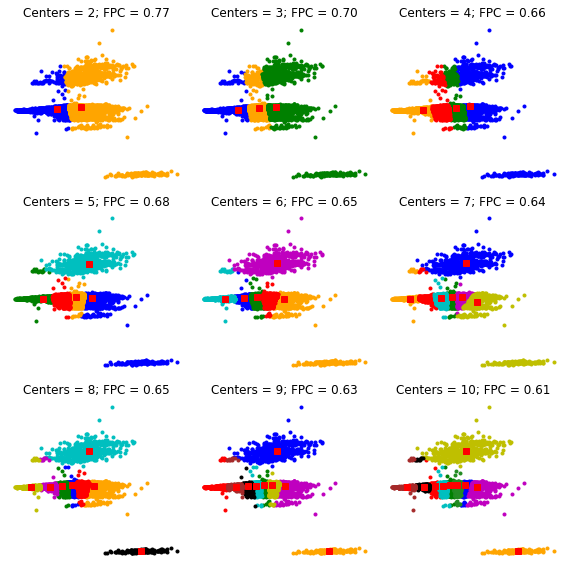

In [19]:
#clustering implementation with fuzzy c-means
alldata = np.vstack((X_train_reduc[0], X_train_reduc[1]))
#Set up the loop and plot
colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']
fig1, axes1 = plt.subplots(3, 3, figsize=(8, 8))
fpcs = []

#checking for the optimal num of clusters with FPC plots
for ncenters, ax in enumerate(axes1.reshape(-1), 2):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        alldata, ncenters, 2, error=0.005, maxiter=1000, init=None)

    # Store fpc values for later
    fpcs.append(fpc)

    # Plot assigned clusters, for each data point in training set
    cluster_membership = np.argmax(u, axis=0)
    for j in range(ncenters):
        ax.plot(X_train_reduc[0][cluster_membership == j],
                X_train_reduc[1][cluster_membership == j], '.', color=colors[j])

    # Mark the center of each fuzzy cluster
    for pt in cntr:
        ax.plot(pt[0], pt[1], 'rs')

    ax.set_title('Centers = {0}; FPC = {1:.2f}'.format(ncenters, fpc))
    ax.axis('off')
fig1.tight_layout()

Text(0, 0.5, 'Fuzzy partition coefficient')

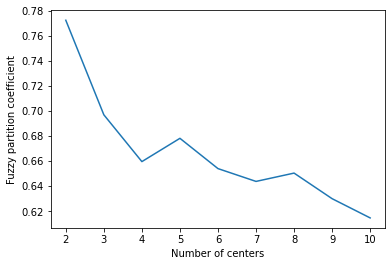

In [20]:
#fpc plot per number of clusters
fig2, ax2 = plt.subplots()
ax2.plot(np.r_[2:11], fpcs)
ax2.set_xlabel("Number of centers")
ax2.set_ylabel("Fuzzy partition coefficient")

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:00<00:00,  7.55s/it]


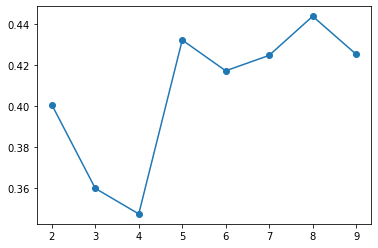

In [21]:
#silhouette score plot per number of cluster
from tqdm import tqdm
n_clusters = []
silhouette_scores = []
for i in tqdm(range(2, 10)):
    try:
        cntr, u_orig, _, _, _, _, _ = fuzz.cluster.cmeans(alldata, i, 2, error=0.005, 
                                                          maxiter=5000)
        u, u0, d, jm, p, fpc = fuzz.cluster.cmeans_predict(X_train_reduc.T, cntr, 2, error=0.005,       
                                                            maxiter=5000)
        clusters = np.argmax(u, axis=0)
        silhouette_val = silhouette_score(X_train_reduc, clusters, 
                                          metric='euclidean')
        silhouette_scores.append(silhouette_val)
        n_clusters.append(i)
    except:
        print(f"Can't cluster with {i} clusters")
plt.scatter(x=n_clusters, y=silhouette_scores)
plt.plot(n_clusters, silhouette_scores)
plt.show()

In [22]:
#predict with the num of clusters desired (5, 6 or 8 seems the best for adult)
n_clust = 5
cntr, u_orig, _, _, _, _, _ = fuzz.cluster.cmeans(alldata, n_clust, 2, error=0.005, 
                                                  maxiter=5000)
# u: final fuzzy-partitioned matrix, u0: initial guess at fuzzy c-partitioned matrix,
# d: final euclidean distance matrix, jm: obj func hist, p: num of iter run, 
#fpc: fuzzy partition coefficient
u, u0, d, jm, p, fpc = fuzz.cluster.cmeans_predict(X_train_reduc.T, cntr, 2, error=0.005,       
                                                   maxiter=5000)
clusters = np.argmax(u, axis=0)  # Hardening for silhouette   
print(silhouette_score(X_train_reduc, clusters, metric='euclidean'))

0.4320893060228006


In [23]:
# Putting the required label info back to the dataframe before oversampling
X_train_new['cluster_labels'] = clusters
X_train_new['cluster_labels'] = X_train_new['cluster_labels'].astype('object')
X_train_new['sub_labels'] = keep_sub_l
# Also put the original decision labels so that they are also oversampled
X_train_new['class_labels'] = y_train

In [24]:
#cluster datasets in their original form
existing_clust = {}
for h in range(len(X_train_new['cluster_labels'].unique())):
   existing_clust[h] = X_train_new.loc[X_train_new['cluster_labels']==h]
#checking the subgroup counts in each cluster dataset
for item in existing_clust:
    print(existing_clust[item]['sub_labels'].value_counts())

#fixing the cluster memberships in each df if a sample from a subgroup is alone
fixed_clusters = fix_memberships_fcm(X_train_new, X_train_reduc, clust_centroids=cntr)
#checking the subgroup counts in each cluster dataset
for item in fixed_clusters:
    print(fixed_clusters[item]['sub_labels'].value_counts())

7    621
6    131
3     89
2     56
5     52
4     19
1      8
0      7
Name: sub_labels, dtype: int64
7    2762
6    1083
2     455
3     344
5     262
4     132
0     110
1      58
Name: sub_labels, dtype: int64
6    1616
7    1298
2     897
3     416
4     266
0     264
5     135
1      66
Name: sub_labels, dtype: int64
7    1417
6     378
3     116
5      99
2      73
4      34
1      12
0       9
Name: sub_labels, dtype: int64
6    967
2    923
0    227
4    198
3     54
7     28
1      6
5      3
Name: sub_labels, dtype: int64
7    621
6    131
3     89
2     56
5     52
4     19
1      8
0      7
Name: sub_labels, dtype: int64
7    2762
6    1083
2     455
3     344
5     262
4     132
0     110
1      58
Name: sub_labels, dtype: int64
6    1616
7    1298
2     897
3     416
4     266
0     264
5     135
1      66
Name: sub_labels, dtype: int64
7    1417
6     378
3     116
5      99
2      73
4      34
1      12
0       9
Name: sub_labels, dtype: int64
6    967
2    923
0    22

In [26]:
#transform the data types of all the columns to numeric for SMOTE
for df in fixed_clusters:
    for i in range(len(fixed_clusters[df].columns)):       
        fixed_clusters[df].iloc[:,i] = fixed_clusters[df].iloc[:,i].astype('float')
    #print(fixed_clusters[df].dtypes)
    
# Over-sampling of each cluster
oversampled_clusters, unique_subl = oversample(fixed_clusters)
for item in oversampled_clusters:
    print(oversampled_clusters[item]['sub_labels'].value_counts())

# Deleting sensitive attributes and subgroup labels from test set is required
# to apply the implemented solutions (sens. attr. are not used to satisfy the
# disparate treatment in the functions)
test_sublabels = X_test['sub_labels']
X_test_n = X_test.drop(['race', 'sex','sub_labels'], axis=1)
num_list, cat_list = type_lists(X_test_n)
X_test_reduc = famd.transform(X_test_n)

7    621
3    621
6    621
2    621
5    621
1    621
4    621
0    621
Name: sub_labels, dtype: int64
7    2762
6    2762
5    2762
4    2762
3    2762
2    2762
1    2762
0    2762
Name: sub_labels, dtype: int64
7    1616
6    1616
5    1616
4    1616
3    1616
2    1616
1    1616
0    1616
Name: sub_labels, dtype: int64
7    1417
6    1417
5    1417
4    1417
3    1417
2    1417
1    1417
0    1417
Name: sub_labels, dtype: int64
7    967
3    967
6    967
2    967
5    967
1    967
4    967
0    967
Name: sub_labels, dtype: int64


### Class Label Predictions per Strategy

In [27]:
# Predicting the test sets based on strategy 1
X_test_pred1 = predict_whole_set(clf, oversampled_clusters, X_test_n)

# Predicting the test sets based on strategy 2
#t_u is needed later for option 3
t_u, u0, d, jm, p, fpc = fuzz.cluster.cmeans_predict(
    X_test_reduc.T, cntr, 2, error=0.005, maxiter=1000)
test_clusts = np.argmax(t_u, axis=0) 
X_test_pred2 = predict_w_fuzzy(clf, oversampled_clusters, X_test_n, 
                               X_test_reduc, cntr, unique_subl, test_sublabels) 

# Predicting the test sets based on strategy 3
X_test_pred3 = predict_w_weights_fuzzy(clf, oversampled_clusters, t_u, 
                                       X_test_n, unique_subl, test_sublabels)

#### The metrics table creation for given dataset: Protected attributes and groups must be defined based on the dataset and preferences to calculate fairness and performance metrics

In [28]:
metrics_table1, cm1, ratio_t1 = metrics_calculate(X_test, X_test_pred1, y_test,
                                                  sens_attr, fav_l, unfav_l)
metrics_table2, cm2, ratio_t2 = metrics_calculate(X_test, X_test_pred2, y_test,
                                                  sens_attr, fav_l, unfav_l)
metrics_table3, cm3, ratio_t3 = metrics_calculate(X_test, X_test_pred3, y_test,
                                                  sens_attr, fav_l, unfav_l)

In [29]:
#outputs from strategy 1
print(metrics_table1)
print("Confusion Matrix:", cm1)
print(ratio_t1)

                                                AEO Difference  \
[{'race': 0, 'sex': 0}][{'race': 1, 'sex': 0}]       -0.060439   
[{'race': 1, 'sex': 0}][{'race': 0, 'sex': 1}]        0.026011   
[{'race': 0, 'sex': 1}][{'race': 1, 'sex': 1}]       -0.041454   
[{'race': 0, 'sex': 0}][{'race': 0, 'sex': 1}]       -0.034427   
[{'race': 1, 'sex': 0}][{'race': 1, 'sex': 1}]       -0.015443   
[{'race': 0, 'sex': 0}][{'race': 1, 'sex': 1}]       -0.075881   

                                                Disparate Impact Ratio  \
[{'race': 0, 'sex': 0}][{'race': 1, 'sex': 0}]                0.651896   
[{'race': 1, 'sex': 0}][{'race': 0, 'sex': 1}]                0.798855   
[{'race': 0, 'sex': 1}][{'race': 1, 'sex': 1}]                0.794343   
[{'race': 0, 'sex': 0}][{'race': 0, 'sex': 1}]                0.520770   
[{'race': 1, 'sex': 0}][{'race': 1, 'sex': 1}]                0.634565   
[{'race': 0, 'sex': 0}][{'race': 1, 'sex': 1}]                0.413670   

                  

In [30]:
#outputs from strategy 2
print(metrics_table2)
print("Confusion Matrix:", cm2)
print(ratio_t2)

                                                AEO Difference  \
[{'race': 0, 'sex': 0}][{'race': 1, 'sex': 0}]       -0.038888   
[{'race': 1, 'sex': 0}][{'race': 0, 'sex': 1}]        0.003412   
[{'race': 0, 'sex': 1}][{'race': 1, 'sex': 1}]       -0.050568   
[{'race': 0, 'sex': 0}][{'race': 0, 'sex': 1}]       -0.035476   
[{'race': 1, 'sex': 0}][{'race': 1, 'sex': 1}]       -0.047156   
[{'race': 0, 'sex': 0}][{'race': 1, 'sex': 1}]       -0.086044   

                                                Disparate Impact Ratio  \
[{'race': 0, 'sex': 0}][{'race': 1, 'sex': 0}]                0.688170   
[{'race': 1, 'sex': 0}][{'race': 0, 'sex': 1}]                0.736566   
[{'race': 0, 'sex': 1}][{'race': 1, 'sex': 1}]                0.775225   
[{'race': 0, 'sex': 0}][{'race': 0, 'sex': 1}]                0.506883   
[{'race': 1, 'sex': 0}][{'race': 1, 'sex': 1}]                0.571004   
[{'race': 0, 'sex': 0}][{'race': 1, 'sex': 1}]                0.392948   

                  

In [31]:
#outputs from strategy 3
print(metrics_table3)
print("Confusion Matrix:", cm3)
print(ratio_t3)

                                                AEO Difference  \
[{'race': 0, 'sex': 0}][{'race': 1, 'sex': 0}]       -0.041181   
[{'race': 1, 'sex': 0}][{'race': 0, 'sex': 1}]        0.005705   
[{'race': 0, 'sex': 1}][{'race': 1, 'sex': 1}]       -0.049920   
[{'race': 0, 'sex': 0}][{'race': 0, 'sex': 1}]       -0.035476   
[{'race': 1, 'sex': 0}][{'race': 1, 'sex': 1}]       -0.044215   
[{'race': 0, 'sex': 0}][{'race': 1, 'sex': 1}]       -0.085396   

                                                Disparate Impact Ratio  \
[{'race': 0, 'sex': 0}][{'race': 1, 'sex': 0}]                0.685273   
[{'race': 1, 'sex': 0}][{'race': 0, 'sex': 1}]                0.739680   
[{'race': 0, 'sex': 1}][{'race': 1, 'sex': 1}]                0.775848   
[{'race': 0, 'sex': 0}][{'race': 0, 'sex': 1}]                0.506883   
[{'race': 1, 'sex': 0}][{'race': 1, 'sex': 1}]                0.573879   
[{'race': 0, 'sex': 0}][{'race': 1, 'sex': 1}]                0.393264   

                  